# PIGA
PIGA is one of several proteins required for the first step of GPI anchor biosynthesis.
[multiple congenital anomalies-hypotonia-seizures syndrome-2 (MCAHS2)](https://omim.org/entry/300868)
and
that neurodevelopmental disorder with epilepsy and hemochromatosis (NEDEPH)](https://omim.org/entry/301072) is caused by hemizygous mutation in the PIGA gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


### PIGA
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for PIGA.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'PIGA'
mane_tx_id = 'NM_002641.4'
mane_protein_id = 'NP_002632.1' # phosphatidylinositol N-acetylglucosaminyltransferase subunit A isoform 1
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.24') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 27/27 [00:00<00:00, 148.28 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
12,Global developmental delay
10,Seizure
9,Hypoplasia of the corpus callosum
9,Hypsarrhythmia
8,Flexion contracture
8,Elevated circulating alkaline phosphatase concentration
7,Generalized myoclonic seizure
7,Cerebral visual impairment
6,Abnormality of the face
6,Hypotonia


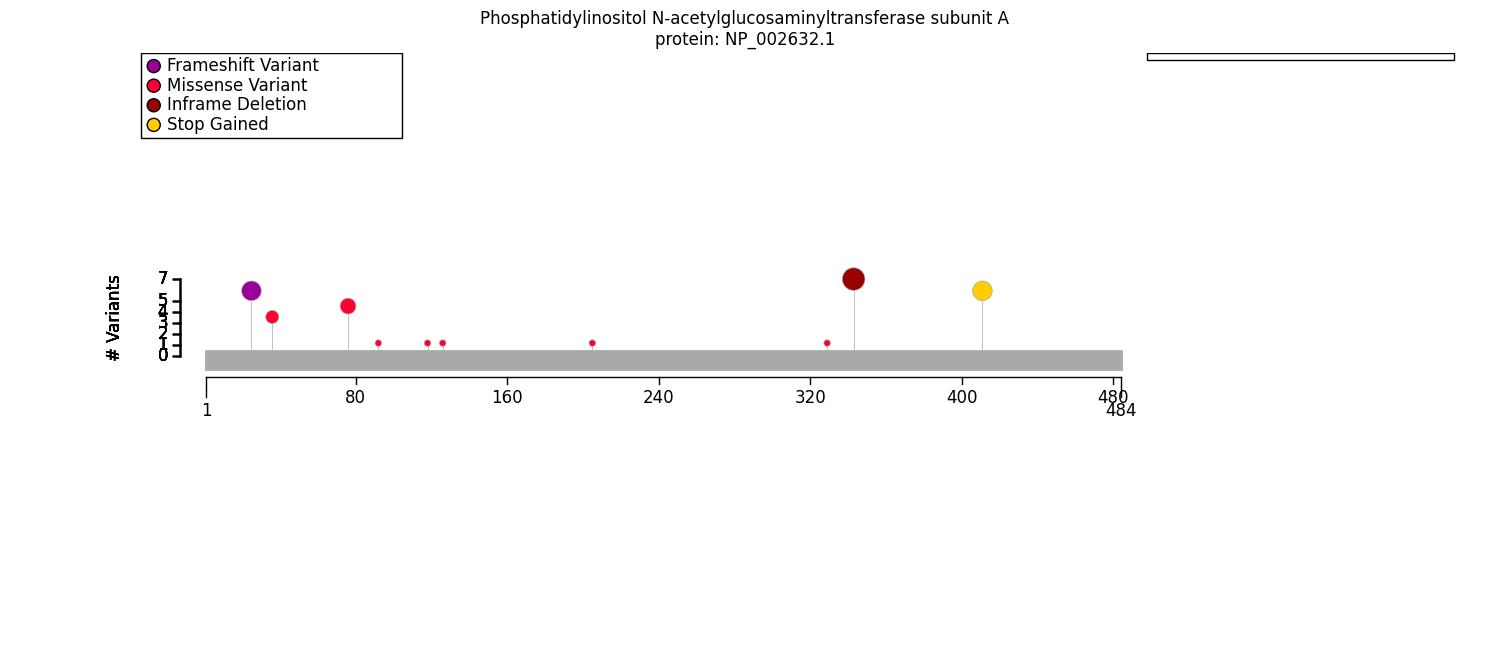

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

piga_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
piga_fig.tight_layout()

# Genotype Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.model.genome import Region
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import protein_region
from gpsea.view import MtcStatsViewer

n_term = protein_region(region=Region(0,200), tx_id=mane_tx_id)

n_term_clf = monoallelic_classifier(a_predicate=n_term, 
                                         b_predicate=~ n_term, 
                                         a_label="1-100",
                                         b_label="100+")
n_term_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=n_term_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(n_term_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,7
"Skipping ""general"" level terms",110
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),409


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=n_term_result)

Allele group,1-100,100+,Corrected p values,p values
Flexion contracture [HP:0001371],1/3 (33%),10/12 (83%),1.0,0.153846
Hypotonia [HP:0001252],5/6 (83%),7/7 (100%),1.0,0.461538
Hyperreflexia [HP:0001347],1/3 (33%),6/9 (67%),1.0,0.522727
Joint contracture [HP:0034392],1/1 (100%),10/10 (100%),1.0,1.000000
Abnormality of joint mobility [HP:0011729],1/1 (100%),10/10 (100%),1.0,1.000000
Abnormal oral cavity morphology [HP:0000163],1/1 (100%),10/10 (100%),1.0,1.000000
Abnormal oral morphology [HP:0031816],1/1 (100%),10/10 (100%),1.0,1.000000
Seizure [HP:0001250],12/12 (100%),13/13 (100%),1.0,1.000000
Neurodevelopmental abnormality [HP:0012759],13/13 (100%),9/9 (100%),1.0,1.000000
Aplasia/Hypoplasia of the cerebrum [HP:0007364],3/3 (100%),11/11 (100%),1.0,1.000000


In [9]:

from gpsea.analysis.predicate import variant_key

l366del = variant_key("X_15324820_15324823_TAAG_T") # c.1030_1032del; p.Leu344del
l366del_clf = monoallelic_classifier(a_predicate=l366del, 
                                         b_predicate=~ l366del, 
                                         a_label="p.Leu344del",
                                         b_label="other")
l366delresult = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=l366del_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=l366delresult)

Allele group,p.Leu344del,other,Corrected p values,p values
Spasticity [HP:0001257],4/5 (80%),4/7 (57%),1.0,0.575758
Hyperreflexia [HP:0001347],2/4 (50%),5/8 (62%),1.0,1.000000
Global developmental delay [HP:0001263],3/3 (100%),10/10 (100%),1.0,1.000000
Aplasia/Hypoplasia of the cerebrum [HP:0007364],4/4 (100%),10/10 (100%),1.0,1.000000
Neurodevelopmental delay [HP:0012758],4/4 (100%),11/11 (100%),1.0,1.000000
Neurodevelopmental abnormality [HP:0012759],4/4 (100%),18/18 (100%),1.0,1.000000
Joint contracture [HP:0034392],4/4 (100%),7/7 (100%),1.0,1.000000
Abnormality of joint mobility [HP:0011729],4/4 (100%),7/7 (100%),1.0,1.000000
Hypotonia [HP:0001252],4/4 (100%),8/9 (89%),1.0,1.000000
Flexion contracture [HP:0001371],4/5 (80%),7/10 (70%),1.0,1.000000


In [10]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect

missense = variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf = monoallelic_classifier(a_predicate=missense, 
                                         b_predicate=~missense, 
                                         a_label="missense",
                                         b_label="other")
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense,other,Corrected p values,p values
Flexion contracture [HP:0001371],2/5 (40%),9/10 (90%),1.0,0.076923
Hyperreflexia [HP:0001347],1/4 (25%),6/8 (75%),1.0,0.222222
Spasticity [HP:0001257],4/7 (57%),4/5 (80%),1.0,0.575758
Seizure [HP:0001250],10/10 (100%),15/15 (100%),1.0,1.000000
Neurodevelopmental abnormality [HP:0012759],11/11 (100%),11/11 (100%),1.0,1.000000
Joint contracture [HP:0034392],2/2 (100%),9/9 (100%),1.0,1.000000
Abnormality of joint mobility [HP:0011729],2/2 (100%),9/9 (100%),1.0,1.000000
Abnormal oral cavity morphology [HP:0000163],3/3 (100%),8/8 (100%),1.0,1.000000
Abnormal oral morphology [HP:0031816],3/3 (100%),8/8 (100%),1.0,1.000000
Neurodevelopmental delay [HP:0012758],5/5 (100%),10/10 (100%),1.0,1.000000


# Summary

In [11]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


FET_results = (
   GPAnalysisResultSummary.from_multi(
        result=missense_result,
    
    ),
    GPAnalysisResultSummary.from_multi(
        result=l366delresult,
    ),
    GPAnalysisResultSummary.from_multi(
        result=n_term_result,
    ),

)


piga_caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=FET_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=piga_caption)

In [12]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense,other,23,0
Genotype (A),Genotype (B),Tests performed,Significant tests
p.Leu344del,other,20,0
Genotype (A),Genotype (B),Tests performed,Significant tests
1-100,100+,23,0


In [13]:
summarizer.process_latex(report=report, protein_fig=piga_fig)

Figure saved to ../../supplement/img/PIGA_protein_diagram-draft.pdf
Output to ../../supplement/tex/PIGA_summary_draft.tex
